
### Source 
[Here](https://github.com/Xianzhiwang1/CS0451-page-site/tree/main/posts/) is a link to the source code for this blog post.

### Reference
[Here](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-bias-allocative.html#what-you-should-do) is a link to the main guide and reference when we write this blog post.

Another reference is this [paper](https://arxiv.org/pdf/2108.04884.pdf) that documents which variable means what in the PUMS data set we are going to use.  

### Introduction.

### Implementation 

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's import some libraries that we need.

In [42]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In the following code cell, we will generate a linearly separable dataset of binary-labeled 2D points. The `make_blobs` function essentially takes $n$ samples, a number of features, and classes, and spits out a dataset of points with a data set with the given size, and label the data points using the classes. Visually, we see two clusters of points of two different color. In this special case where I set the seed, those two clusters seems linearly separable, which just means we could draw a straight line that completely seprates them. If we go to higher dimensions, then we need precise mathematical definitions, but we don't need to worry about that right now.

# Getting the data using `folktables`

In [44]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter

STATE = "IN"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

In [45]:
acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000042,3,1,2000,2,18,1013097,46,20,...,7,6,82,44,6,76,83,44,45,44
1,P,2018GQ0000053,3,1,2306,2,18,1013097,19,48,...,16,19,37,23,2,19,2,2,40,18
2,P,2018GQ0000074,3,1,2000,2,18,1013097,88,20,...,166,158,160,90,87,84,88,90,13,166
3,P,2018GQ0000118,3,1,401,2,18,1013097,72,20,...,11,10,11,11,71,11,70,11,74,135
4,P,2018GQ0000319,3,1,200,2,18,1013097,97,22,...,15,170,93,181,175,92,174,16,96,95


# Data wrangling, applying Logistic Regression 
We recall the equation for a linear regression first:
$$ y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n, $$
where, $\beta_i$'s are coefficients, $y$ is the depedent variable, and the $X_i$'s are regressors (independent variables). Now, we recall logistic function (or sigmoid function), which is 
$$ f(x) = \frac{1}{1+e^{-x}}, $$
and when we put those two piece together, we obtain the formula for logistic regression:
$$ y = \frac{1}{1+e^{\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n}}, $$ 
        





Here are some of the variables that are important for our analysis:
* `PINCP` is total personal income.
* `ESR` is employment status coded as a dummy variable (`1` if employed, `0` if not) 
* `SEX` is binary sex, coded `1` for male, and `2` for female.
* `RAC1P` is race (`1`for White Alone, `2` for Black/African American alone, `3` and above for other self-identified racial groups)
* `DEAR`, `DEYE`, and `DERM` refers to disability status relating to ear, eye, etc.
* `AGEP` is Age, represented as integers.
* `SCHL` is educational attainment, coded as integers.
* `MAR` is Marital status, coded using integers.
* `RELP` is Relationship.
* `COW` is class of worker, coded using integers.
* `OCCP` is occupation.
* `POBP` is place of birth.
* `WKHP` is usual hours worked per week in the past 12 months.  


<p>Let’s consider the following task: we are going to</p>

<li>Train a machine learning algorithm to predict whether someone is currently employed, based on their other attributes <em>not</em> including race, and</li>
<li>Perform a bias audit of our algorithm to determine whether it displays racial bias.</li>

<p>First, let’s be more specific:</p>

In [46]:
my_features=['PINCP', 'ESR', 'AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
# new_df = acs_data[my_features]
# new_df['INCOME'] = np.where(new_df['PINCP'] >= 70000, 1, 0)

In [47]:
# new_df.loc[new_df['PINCP'] >= 70000]
# new_df.loc[new_df['ESR'] == 1]

In [48]:
features_to_use = [f for f in my_features if f not in ["ESR", "RAC1P"]]

In [49]:
print(features_to_use)

['PINCP', 'AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX']


In [50]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    # group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

In [51]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Working with `pd.DataFrame`, apply logistic regression in Python with scikit-learn.

In [52]:

df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

In [53]:
# df.loc[df['group'] == 2]
df.head()

,PINCP,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,0.0,31.0,20.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,1,False
1,32000.0,50.0,18.0,5.0,0.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,1,True
2,0.0,2.0,0.0,5.0,2.0,2.0,5.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,0.0,1.0,1,False
3,0.0,14.0,9.0,5.0,2.0,2.0,7.0,1.0,3.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,1,False
4,38000.0,58.0,21.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,1,True


### Basic Discriptives

Using this data frame, we first answer the following questions:

* How many individuals are in the data?
* Of these individuals, what proportion have target label equal to 1? In employment prediction, these would correspond to employed individuals.
* Of these individuals, how many are in each of the groups?
* In each group, what proportion of individuals have target label equal to 1?
* Check for intersectional trends by studying the proportion of positive target labels broken out by your chosen group labels and an additional group label. For example, if you chose race (RAC1P) as your group, then you could also choose sex (SEX) and compute the proportion of positive labels by both race and sex. This might be a good opportunity to use a visualization such as a bar chart, e.g. via the seaborn package.

In [54]:
print(f"The Number of Rows is: {df.shape[0]}")
print(f"The Number of Columns is: {df.shape[1]}")
print(f"The Number of individual who are employed is: {df.loc[df['label'] == True].shape[0]}")
print(f"The Percentage of individuals who are employed is: {24858/54144}")
###
print(f"The Number of person who identify as black is: {df.loc[df['group']==2].shape[0]}")
print(f"The Number of person who identify as white is: {df.loc[df['group']==1].shape[0]}")
print(f"The Number of person who identify as black and is currently employed: {df.loc[(df['group']==2) & (df['label']==True)].shape[0]}")
print(f"The Number of person who identify as white and is currently employed: {df.loc[(df['group']==1) & (df['label']==True)].shape[0]}")
###
print(f"The Number of person who identify as other racial groups is: {df.loc[df['group']>= 3].shape[0]}")
print(f"The Number of person who identify as other racial groups and is currently employed: {df.loc[(df['group']>= 3) & (df['label']==True)].shape[0]}")
###
print(f"The Percentage of person who identify as black and is also employed is: {1374/3626}")
print(f"The Percentage of person who identify as white and is also employed is: {22200/47332}")
print(f"The Percentage of person who identify as other racial groups and is also employed is: {1284/3186}")

The Number of Rows is: 54144
The Number of Columns is: 18
The Number of individual who are employed is: 24858
The Percentage of individuals who are employed is: 0.4591090425531915
The Number of person who identify as black is: 3626
The Number of person who identify as white is: 47332
The Number of person who identify as black and is currently employed: 1374
The Number of person who identify as white and is currently employed: 22200
The Number of person who identify as other racial groups is: 3186
The Number of person who identify as other racial groups and is currently employed: 1284
The Percentage of person who identify as black and is also employed is: 0.3789299503585218
The Percentage of person who identify as white and is also employed is: 0.4690272965435646
The Percentage of person who identify as other racial groups and is also employed is: 0.4030131826741996


In [55]:
print( df.groupby("SEX").size() )
print("***")
print( df.groupby("group").size() )
print("***")
print( df.groupby("label").size() )
print("***")
print( df.groupby(['group', 'label']).size())
print("***")
print("the average employment rate is: " , df["label"].mean())


SEX
1.0    26578
2.0    27566
dtype: int64
***
group
1    47332
2     3626
3       83
4        1
5       29
6      942
7       17
8      906
9     1208
dtype: int64
***
label
False    29286
True     24858
dtype: int64
***
group  label
1      False    25132
       True     22200
2      False     2252
       True      1374
3      False       50
       True        33
4      True         1
5      False       17
       True        12
6      False      492
       True       450
7      False        6
       True        11
8      False      516
       True       390
9      False      821
       True       387
dtype: int64
***
the average employment rate is:  0.4591090425531915



The following code is much more efficient, it shows the employment rate for each group. The employment rate for white people in IN in 2018 is $47$ percent. The employment for black people in IN in 2018 is $37.9$ percent.


In [56]:
print( df.groupby("group")["label"].mean() )

group
1    0.469027
2    0.378930
3    0.397590
4    1.000000
5    0.413793
6    0.477707
7    0.647059
8    0.430464
9    0.320364
Name: label, dtype: float64


More efficiently, we could use the following line of code and read off the numbers that for people identifying as white male, the employment rate is $50.7$ percent. For people identifying as white female, the employment rate is $43.2$ percent.

In [57]:
df.groupby(["group","SEX"])["label"].mean()

group  SEX
1      1.0    0.507493
       2.0    0.431978
2      1.0    0.357579
       2.0    0.400000
3      1.0    0.348837
       2.0    0.450000
4      2.0    1.000000
5      1.0    0.352941
       2.0    0.500000
6      1.0    0.510067
       2.0    0.448485
7      1.0    0.666667
       2.0    0.625000
8      1.0    0.475877
       2.0    0.384444
9      1.0    0.312178
       2.0    0.328000
Name: label, dtype: float64

The below graph shows the number of female in each racial group and male in each racial group.

<AxesSubplot:xlabel='SEX', ylabel='n'>

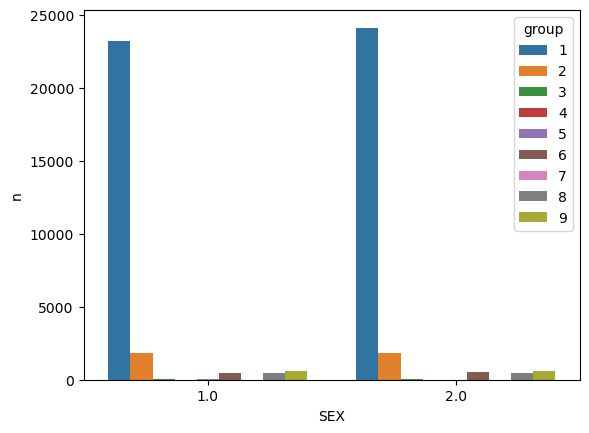

In [58]:
counts = df.groupby(["group", "SEX"]).size().reset_index(name = "n")
sns.barplot(data = counts, x = "SEX", y = "n", hue = "group")

<AxesSubplot:xlabel='SEX', ylabel='label'>

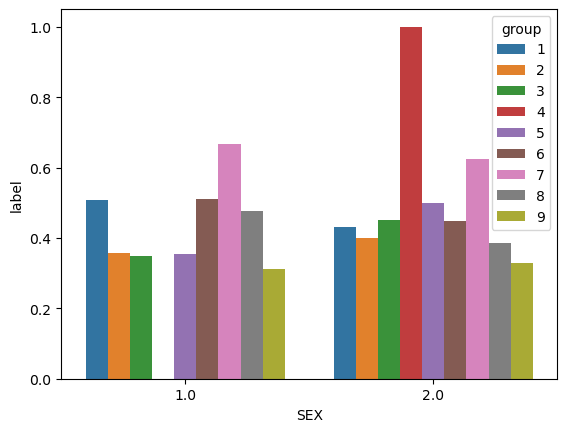

In [59]:

percentages = df.groupby(["group", "SEX"])["label"].mean().reset_index()
sns.barplot(data = percentages, x = "SEX", y = "label", hue = "group")

The number of persons in the data set is $54144.$ The percentage of individuals who are employed is about $46$ percent.

In [60]:

# model = make_pipeline(StandardScaler(), LogisticRegression())
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [61]:
y_hat = model.predict(X_test)

In [62]:
print(f" The overall accuracy in predicting whether someone is employed in 2018 in Indiana is: {(y_hat == y_test).mean()}", "\n",
    f" The accuracy for white individuals is {(y_hat == y_test)[group_test == 1].mean()}", "\n", 
    f" The accuracy for black individuals is {(y_hat == y_test)[group_test == 2].mean()}")

 The overall accuracy in predicting whether someone is employed in 2018 in Indiana is: 0.8331855791962175 
  The accuracy for white individuals is 0.8338424983027835 
  The accuracy for black individuals is 0.8265086206896551


### Train my model

In [63]:
regress = model.fit(X_train, y_train)

In [64]:
regress.score(X_test, y_test)

0.8331855791962175

In [65]:
model.score(X_test, y_test)

0.8331855791962175

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.82      0.89      0.85      7277
        True       0.86      0.77      0.81      6259

    accuracy                           0.83     13536
   macro avg       0.84      0.83      0.83     13536
weighted avg       0.83      0.83      0.83     13536



# Audit the model

### Overall Measures
* What is the overall accuracy of your model?
* What is the positive predictive value (PPV) of your model?
* What are the overall false negative and false positive rates (FNR and FPR) for your model?
### By-Group Measures
* What is the accuracy of your model on each subgroup?
* What is the PPV of your model on each subgroup?
* What are the FNR and FPR on each subgroup?
### Bias Measures
* See Chouldechova (2017) for definitions of these terms. For calibration, you can think of the score as having only two values, 0 and 1.
* Is your model approximately calibrated?
* Does your model satisfy approximate error rate balance?
* Does your model satisfy statistical parity?

In [67]:

for obj in [features, label, group]:
  print(obj.shape)

print(features)
print(group)
print(label)

(67680, 16)
(67680,)
(67680,)
[[1.70e+03 2.00e+01 1.90e+01 ... 2.00e+00 2.00e+00 2.00e+00]
 [9.80e+03 4.80e+01 1.30e+01 ... 2.00e+00 1.00e+00 2.00e+00]
 [3.50e+03 2.00e+01 1.90e+01 ... 2.00e+00 2.00e+00 1.00e+00]
 ...
 [2.11e+04 6.70e+01 1.60e+01 ... 1.00e+00 2.00e+00 1.00e+00]
 [8.40e+03 6.70e+01 1.90e+01 ... 2.00e+00 2.00e+00 2.00e+00]
 [5.50e+04 6.70e+01 2.10e+01 ... 2.00e+00 2.00e+00 1.00e+00]]
[9 1 1 ... 1 1 1]
[False False False ... False False  True]


Recall that:
* upper-left corner is `TN`, which stands for `True negative`
* lower-left corner is `FN`, `False negative` 
* upper-right corner is `FP`, which stands for `False positive`
* lower-right corner is `TP`, `True positive` 


We also care about the `FPR`, which stands for the false positive rate, which is top-right corner of the confusion matrix (after we normalize).  `FNR` is false negative rate.

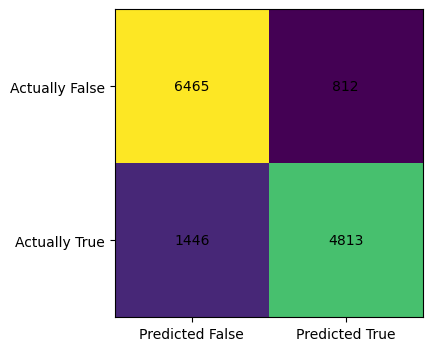

In [68]:
my_matr = confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(my_matr)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted False', 'Predicted True'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actually False', 'Actually True'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j,i, my_matr[i,j], ha='center', va='center', color='black')

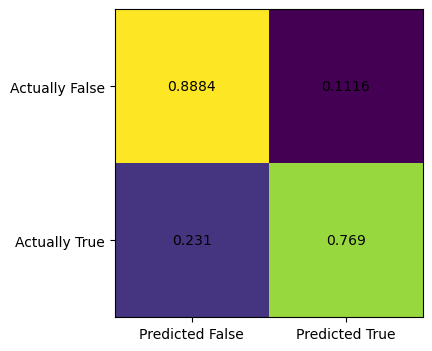

In [69]:

my_matr = confusion_matrix(y_test, model.predict(X_test), normalize="true")
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(my_matr)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted False', 'Predicted True'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actually False', 'Actually True'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j,i, my_matr[i,j].round(4), ha='center', va='center', color='black')

### Concluding Discussion